In [1]:
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest, f_classif

### Transfer Learning Using EfficientNetV2M: Extracting features from the penultimate layer

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M, preprocess_input
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

base_model = EfficientNetV2M()
feature_extractor = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
feature_extractor.summary()

### Transfer Learning Using VGG16: Extracting features from the penultimate layer

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

base_model = VGG16()
# base_model.inputs
feature_extractor = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
# feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Transfer Learning Using ResNet50: Extracting features from the penultimate layer

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

model = ResNet50()
# summarize the model
feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-2].output)
feature_extractor.summary()

### Transfer Learning Using NasNetLarge: Extracting features from the penultimate layer

In [ ]:
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input

model = NASNetLarge()
# summarize the model
feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-2].output)
feature_extractor.summary()

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image, ImageChops, ImageEnhance
from tqdm import tqdm


def calculate_ela(image_path, quality=80):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(image_path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image
    

def prepare_image(image_path):
    image_size = (224, 224)
    img = np.array(calculate_ela(image_path, 80).resize(image_size))
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]

    r_filtered = freq_process(r)
    g_filtered = freq_process(g)  
    b_filtered = freq_process(b)

    enhanced_img = np.dstack((r_filtered, g_filtered, b_filtered))
    return enhanced_img / 255


def freq_process(img):
    img_fft = np.fft.fft2(img)

    img_fft_shifted = np.fft.fftshift(img_fft)  

    rows, cols = img.shape
    crow, ccol = int(rows/2), int(cols/2) 
    sigma = 50
    gauss_filt = gaussian_filter(img, sigma)
    fft_gauss = np.fft.fftshift(np.fft.fft2(gauss_filt))
    fft_mask = np.ones((rows, cols))  
    fft_mask[crow-30:crow+30, ccol-30:ccol+30] = 0
    high_pass_filter = 1 - fft_mask * fft_gauss

    # Apply filter
    img_fft_shifted = img_fft_shifted * high_pass_filter
    img_enhanced = np.fft.ifft2(np.fft.ifftshift(img_fft_shifted))
    return img_enhanced
    

def get_features(directory):
    feature_vector = list()
    target_size = (224, 224)
    
    for folder in ['/au/', '/tp/']:
        for image in tqdm(os.listdir(directory + folder)):
            if 'jpg' not in image and 'jpeg' not in image:
                continue
                
            image_path = directory + folder + image
            try:
                calculate_ela(image_path)
                img = load_img('temp_ela.jpg', target_size=target_size)
                os.remove('temp_ela.jpg')
            except:
                print(image_path)
                continue
            
#             img = img_to_array(img)
            img = img.reshape((1, *(target_size), 3))
#             img = preprocess_input(img)
            feature = feature_extractor.predict(img, verbose=0)
            feature_vector.append(([0] if 'au' in folder else [1]) + list(feature[0]))


    return pd.DataFrame(feature_vector)
directory_MICC_F2000 = '../Data/MICC-F2000/'
df = get_features(directory_MICC_F2000)

In [4]:
def evaluate(y_test, predictions):
    print(accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

### MICC-F2000

In [ ]:
directory_MICC_F2000 = '../Data/MICC-F2000/'
df = get_features(directory_MICC_F2000)

In [7]:
df.shape

(2000, 4097)

In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,0,0.0,0.0,1.356115,0.0,0.516344,0.0,0.0,0.0,0.336769,...,0.000000,1.644864,0.890650,0.637074,0.675974,0.077491,0.531071,0.0,0.0,0.436426
1,0,0.0,0.0,1.352393,0.0,0.465959,0.0,0.0,0.0,0.342205,...,0.000000,1.598152,0.924850,0.735847,0.688578,0.032272,0.610149,0.0,0.0,0.426123
2,0,0.0,0.0,1.288568,0.0,0.443177,0.0,0.0,0.0,0.366383,...,0.000000,1.576057,0.892327,0.635497,0.707272,0.087511,0.588448,0.0,0.0,0.447805
3,0,0.0,0.0,1.299131,0.0,0.432312,0.0,0.0,0.0,0.335460,...,0.000000,1.583389,0.898172,0.660263,0.720819,0.098063,0.582500,0.0,0.0,0.431403
4,0,0.0,0.0,1.347919,0.0,0.463399,0.0,0.0,0.0,0.344617,...,0.001894,1.596485,0.911214,0.673154,0.651232,0.122738,0.571564,0.0,0.0,0.418372


In [9]:
scaler = MinMaxScaler() 
y = df.loc[:, 0]
X = df.drop(columns=[0], axis=1)

scaler.fit(X)
X = scaler.transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [11]:
# {'C': 10, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}
# model = SVC(C=10, degree=2, gamma=0.01, kernel='poly')
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

0.9625
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       259
           1       0.91      0.99      0.95       141

    accuracy                           0.96       400
   macro avg       0.95      0.97      0.96       400
weighted avg       0.96      0.96      0.96       400



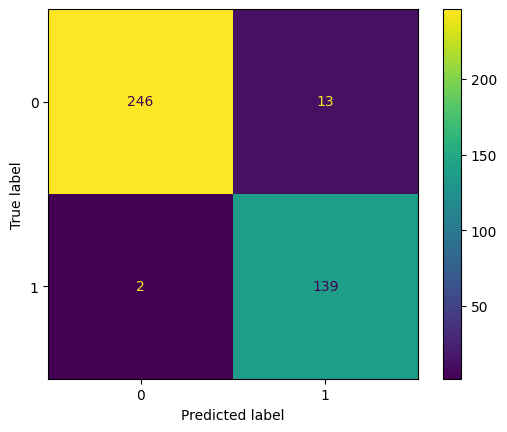

In [12]:
evaluate(y_test, predictions)

In [ ]:
# Training using selected features
df_new = SelectKBest(f_classif, k=1400).fit_transform(X, y)
print(X.shape, df_new.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size=0.20, random_state=5)

In [ ]:
model = SVC(C=10, degree=2, gamma=0.01, kernel='poly')

model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [ ]:
evaluate(y_test, predictions)

### CASIA 1.0

In [13]:
directory_CASIA_10 = '../Data/CASIA 1.0 dataset/'
df = get_features(directory_CASIA_10)

  8%|██████▍                                                                          | 64/800 [00:38<07:18,  1.68it/s]

../Data/CASIA 1.0 dataset//au/Au_ani_0065.jpg


 19%|███████████████▎                                                                | 153/800 [01:28<05:37,  1.92it/s]

../Data/CASIA 1.0 dataset//au/Au_arc_0054.jpg


 60%|███████████████████████████████████████████████▉                                | 479/800 [04:06<02:26,  2.19it/s]

../Data/CASIA 1.0 dataset//au/Au_nat_0080.jpg


100%|████████████████████████████████████████████████████████████████████████████████| 921/921 [10:42<00:00,  1.43it/s]


In [14]:
df.shape

(1708, 4097)

In [15]:
scaler = MinMaxScaler() 
y = df.loc[:, 0]
X = df.drop(columns=[0], axis=1)

scaler.fit(X)
display(X.head())
X = scaler.transform(X)

,1,2,3,4,5,6,7,8,9,10,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,0.0,1.202302,0.858809,0.247183,0.148879,0.531189,0.320942,0.0,0.191305,0.0,...,0.348909,0.099328,0.455924,0.000000,0.997588,1.328276,1.078137,0.0,0.0,0.089428
1,0.0,0.619071,0.000000,0.878242,0.000000,0.000000,1.363943,0.0,0.000000,0.0,...,0.000000,0.000000,0.916154,0.000000,0.587847,2.060640,1.106342,0.0,0.0,0.000000
2,0.0,0.345135,0.615797,0.000000,0.000000,2.105251,1.560729,0.0,0.000000,0.0,...,0.179661,0.000000,0.032425,0.163506,0.556751,1.470330,1.154547,0.0,0.0,0.000000
3,0.0,0.458262,1.460539,0.176270,0.000000,1.616017,1.756065,0.0,0.000000,0.0,...,0.333037,0.276507,0.000000,0.606971,0.202005,0.995773,1.227353,0.0,0.0,0.000000
4,0.0,0.692121,0.980543,0.290235,0.546538,0.401572,0.000000,0.0,0.710866,0.0,...,0.612948,0.472990,0.718351,0.095451,0.595789,1.030007,0.769975,0.0,0.0,0.589249


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [17]:
# model = SVC(kernel='rbf')  
model = XGBClassifier()
model.fit(X_train, y_train) 
predictions = model.predict(X_test)

0.7134502923976608
              precision    recall  f1-score   support

           0       0.70      0.59      0.64       147
           1       0.72      0.81      0.76       195

    accuracy                           0.71       342
   macro avg       0.71      0.70      0.70       342
weighted avg       0.71      0.71      0.71       342



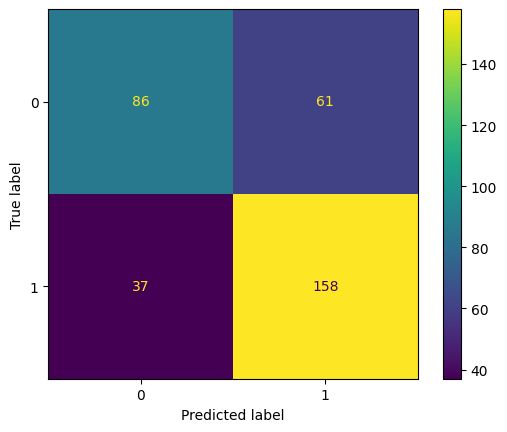

In [18]:
# 80%->0.82267, 85%->0.762318, 87%->0.820289, 89->0.7275362, 93%->0.7594202,77%->0.79420289, 82%->0.762318840, 81%->0.773913043
# 79%->0.736231

# grayscale@80% ela->0.811046511
evaluate(y_test, predictions)

### CASIA 2

In [ ]:
directory_CASIA_2 = '../Data/CASIA2'
df = get_features(directory_CASIA_2)

In [5]:
scaler = MinMaxScaler() 
y = df.loc[:, 0]
X = df.drop(columns=[0], axis=1)

scaler.fit(X)
display(X.head())
X = scaler.transform(X)

,1,2,3,4,5,6,7,8,9,10,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,4096
0,0.0,0.0,1.323303,0.0,0.382743,0.000000,0.0,0.0,0.272961,0.0,...,0.0,1.669941,0.973317,0.716546,0.713553,0.000000,0.595858,0.0,0.0,0.458648
1,0.0,0.0,1.314482,0.0,0.374393,0.080690,0.0,0.0,0.140903,0.0,...,0.0,1.587974,0.937440,0.548906,0.629472,0.095421,0.495456,0.0,0.0,0.469966
2,0.0,0.0,1.333825,0.0,0.473983,0.000000,0.0,0.0,0.178487,0.0,...,0.0,1.485624,1.005591,0.496943,0.668992,0.209244,0.552382,0.0,0.0,0.408192
3,0.0,0.0,1.343615,0.0,0.422353,0.015391,0.0,0.0,0.254647,0.0,...,0.0,1.636598,1.026179,0.651270,0.710039,0.035675,0.576423,0.0,0.0,0.396994
4,0.0,0.0,1.349687,0.0,0.519070,0.000000,0.0,0.0,0.330695,0.0,...,0.0,1.644725,1.151238,0.685685,0.757981,0.029407,0.686268,0.0,0.0,0.421245


In [14]:
# np.save('./Saved_numpy/X_casia2.npy', X)
# np.save('./Saved_numpy/y_casia2.npy', y)

X = np.load('./Saved_numpy/X_casia2.npy')
y = np.load('./Saved_numpy/y_casia2.npy')

In [7]:
from sklearn.decomposition import PCA

feature = np.array(X)
pca = PCA(n_components=300)
pca.fit(feature)
X = pca.transform(feature)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [16]:
# model = SVC(kernel='rbf')
model = XGBClassifier()
model.fit(X_train, y_train) 
predictions = model.predict(X_test)

0.8314829500396511
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1545
           1       0.78      0.78      0.78       977

    accuracy                           0.83      2522
   macro avg       0.82      0.82      0.82      2522
weighted avg       0.83      0.83      0.83      2522



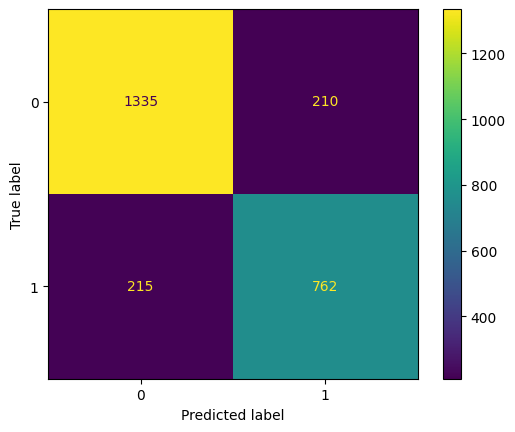

In [17]:
evaluate(y_test, predictions)

In [ ]:
from sklearn.model_selection import KFold

parameters = {'kernel':['poly'], 'degree':[2, 3], 'C':[1, 10, 100, 500], 'gamma': [0.001, 0.001]}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='accuracy', verbose=3, cv=KFold(n_splits=5, shuffle=True))
res = clf.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (res.best_score_, res.best_params_))

In [ ]:
model = SVC(kernel='poly', C=10, degree=2, gamma=0.01)
model.fit(X_train, y_train) 
predictions = model.predict(X_test)

In [ ]:
evaluate(y_test, predictions)

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=1000, learning_rate='adaptive').fit(X_train, y_train)
predictions = clf.predict(X_test)

evaluate(y_test, predictions)

### MICC 220

In [63]:
directory_MICC_220 = '../Data/micc220/'
df = get_features(directory_MICC_220)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:16<00:00,  4.98it/s]


In [64]:
scaler = MinMaxScaler() 
y = df.loc[:, 0]
X = df.drop(columns=[0], axis=1)

scaler.fit(X)
X = scaler.transform(X)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [66]:
model = SVC(kernel='rbf')
model.fit(X_train, y_train) 

SVC()

In [67]:
predictions = model.predict(X_test)

0.9354838709677419
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.89      1.00      0.94        17

    accuracy                           0.94        31
   macro avg       0.95      0.93      0.93        31
weighted avg       0.94      0.94      0.93        31



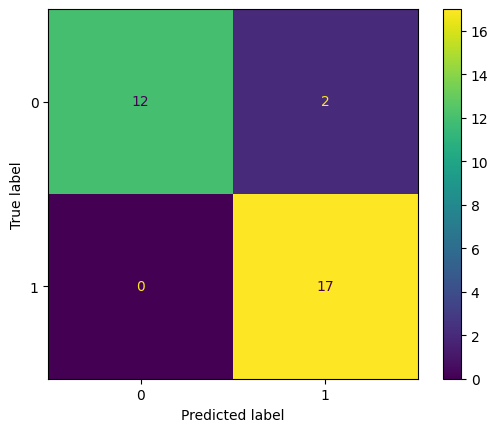

In [68]:
evaluate(y_test, predictions)

In [69]:
from sklearn.model_selection import KFold

parameters = {'kernel':['poly'], 'degree':[2, 3], 'C':[1, 10, 100, 500], 'gamma': [0.1, 0.01, 0.01]}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='accuracy', verbose=3, cv=KFold(n_splits=10, shuffle=True))
res = clf.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV 1/10] END C=1, degree=2, gamma=0.1, kernel=poly;, score=0.923 total time=   0.0s
[CV 2/10] END C=1, degree=2, gamma=0.1, kernel=poly;, score=0.917 total time=   0.0s
[CV 3/10] END C=1, degree=2, gamma=0.1, kernel=poly;, score=0.750 total time=   0.0s
[CV 4/10] END C=1, degree=2, gamma=0.1, kernel=poly;, score=0.917 total time=   0.0s
[CV 5/10] END C=1, degree=2, gamma=0.1, kernel=poly;, score=0.917 total time=   0.0s
[CV 6/10] END C=1, degree=2, gamma=0.1, kernel=poly;, score=1.000 total time=   0.0s
[CV 7/10] END C=1, degree=2, gamma=0.1, kernel=poly;, score=0.917 total time=   0.0s
[CV 8/10] END C=1, degree=2, gamma=0.1, kernel=poly;, score=0.917 total time=   0.0s
[CV 9/10] END C=1, degree=2, gamma=0.1, kernel=poly;, score=0.917 total time=   0.0s
[CV 10/10] END C=1, degree=2, gamma=0.1, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/10] END C=1, degree=2, gamma=0.01, kernel=poly;, score=0.923 total time=   0.0s


[CV 6/10] END C=10, degree=3, gamma=0.01, kernel=poly;, score=1.000 total time=   0.0s
[CV 7/10] END C=10, degree=3, gamma=0.01, kernel=poly;, score=0.833 total time=   0.0s
[CV 8/10] END C=10, degree=3, gamma=0.01, kernel=poly;, score=0.917 total time=   0.0s
[CV 9/10] END C=10, degree=3, gamma=0.01, kernel=poly;, score=0.917 total time=   0.0s
[CV 10/10] END C=10, degree=3, gamma=0.01, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/10] END C=10, degree=3, gamma=0.01, kernel=poly;, score=0.846 total time=   0.0s
[CV 2/10] END C=10, degree=3, gamma=0.01, kernel=poly;, score=0.917 total time=   0.0s
[CV 3/10] END C=10, degree=3, gamma=0.01, kernel=poly;, score=0.750 total time=   0.0s
[CV 4/10] END C=10, degree=3, gamma=0.01, kernel=poly;, score=1.000 total time=   0.0s
[CV 5/10] END C=10, degree=3, gamma=0.01, kernel=poly;, score=0.917 total time=   0.0s
[CV 6/10] END C=10, degree=3, gamma=0.01, kernel=poly;, score=1.000 total time=   0.0s
[CV 7/10] END C=10, degree=3, gamma=0.01, 

[CV 7/10] END C=500, degree=2, gamma=0.01, kernel=poly;, score=0.917 total time=   0.0s
[CV 8/10] END C=500, degree=2, gamma=0.01, kernel=poly;, score=0.917 total time=   0.0s
[CV 9/10] END C=500, degree=2, gamma=0.01, kernel=poly;, score=0.917 total time=   0.0s
[CV 10/10] END C=500, degree=2, gamma=0.01, kernel=poly;, score=0.833 total time=   0.0s
[CV 1/10] END C=500, degree=3, gamma=0.1, kernel=poly;, score=0.846 total time=   0.0s
[CV 2/10] END C=500, degree=3, gamma=0.1, kernel=poly;, score=0.917 total time=   0.0s
[CV 3/10] END C=500, degree=3, gamma=0.1, kernel=poly;, score=0.750 total time=   0.0s
[CV 4/10] END C=500, degree=3, gamma=0.1, kernel=poly;, score=1.000 total time=   0.0s
[CV 5/10] END C=500, degree=3, gamma=0.1, kernel=poly;, score=0.917 total time=   0.0s
[CV 6/10] END C=500, degree=3, gamma=0.1, kernel=poly;, score=1.000 total time=   0.0s
[CV 7/10] END C=500, degree=3, gamma=0.1, kernel=poly;, score=0.833 total time=   0.0s
[CV 8/10] END C=500, degree=3, gamma=0

In [ ]:
print("Best: %f using %s" % (res.best_score_, res.best_params_))

In [ ]:
from sklearn.model_selection import KFold

parameters = {'kernel':['poly'], 'degree':[2, 3], 'C':[1, 10, 100, 500], 'gamma': [0.1, 0.01, 0.01]}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='accuracy', verbose=3, cv=KFold(n_splits=10, shuffle=True))
opt_model = clf.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (opt_model.best_score_, opt_model.best_params_))

### IEEE IFS-TC

In [71]:
directory_MICC_220 = '../Data/IEEE IFS-TC/'
df = get_features(directory_MICC_220)

100%|████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:00<?, ?it/s]


In [72]:
len(df[0] == 0), len(df[df[0] == 1])

KeyError: 0

In [ ]:
scaler = MinMaxScaler() 
y = df.loc[:, 0]
X = df.drop(columns=[0], axis=1)

scaler.fit(X)
X = scaler.transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [ ]:
model = SVC(kernel='rbf')
model.fit(X_train, y_train) 
predictions = model.predict(X_test)

In [ ]:
evaluate(y_test, predictions)